## Ejercicio 2 - Serpientes y escalera

Entorno Jupyter detectado. Se utilizará ThreadPoolExecutor en lugar de ProcessPoolExecutor.
Resultados de la Simulación de Monte Carlo para cada casilla (num_simulaciones = 20000):
Casilla 1: Promedio de turnos = 39.90, Intervalo de Confianza (95%) = [39.56, 40.24]
Casilla 2: Promedio de turnos = 40.16, Intervalo de Confianza (95%) = [39.82, 40.51]
Casilla 3: Promedio de turnos = 39.48, Intervalo de Confianza (95%) = [39.13, 39.82]
Casilla 4: Promedio de turnos = 40.38, Intervalo de Confianza (95%) = [40.04, 40.72]
Casilla 5: Promedio de turnos = 40.23, Intervalo de Confianza (95%) = [39.89, 40.57]
Casilla 6: Promedio de turnos = 39.37, Intervalo de Confianza (95%) = [39.02, 39.71]
Casilla 7: Promedio de turnos = 39.12, Intervalo de Confianza (95%) = [38.78, 39.46]
Casilla 8: Promedio de turnos = 38.82, Intervalo de Confianza (95%) = [38.47, 39.16]
Casilla 9: Promedio de turnos = 38.97, Intervalo de Confianza (95%) = [38.63, 39.31]
Casilla 10: Promedio de turnos = 39.41, Intervalo de C

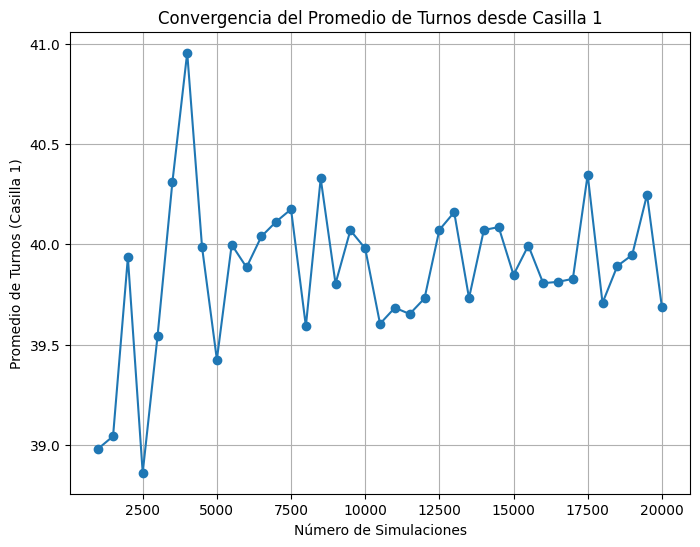

In [1]:
import sys
import numpy as np
import random
from scipy.stats import norm
from concurrent.futures import ProcessPoolExecutor, ThreadPoolExecutor
import matplotlib.pyplot as plt

# Detectar si se está ejecutando en un entorno interactivo (por ejemplo, Jupyter)
if "ipykernel" in sys.modules:
    print("Entorno Jupyter detectado. Se utilizará ThreadPoolExecutor en lugar de ProcessPoolExecutor.")
    Executor = ThreadPoolExecutor
else:
    Executor = ProcessPoolExecutor

class Tablero:
    def __init__(self):
        self.casillas = np.arange(101)
        self.escaleras = {4: 56, 12: 50, 14: 55, 22: 58, 41: 79, 54: 88}
        self.serpientes = {37: 3, 28: 10, 47: 16, 75: 32, 94: 71, 96: 42}
        self._configurar_tablero()

    def _configurar_tablero(self):
        for inicio, fin in self.escaleras.items():
            self.casillas[inicio] = fin
        for inicio, fin in self.serpientes.items():
            self.casillas[inicio] = fin

    def aplicar_reglas(self, posicion):
        return self.casillas[posicion]

class Juego:
    def __init__(self, tablero):
        self.tablero = tablero

    def lanzar_dado(self):
        return random.randint(1, 6)

    def jugar(self, posicion_inicial):
        posicion = posicion_inicial
        turnos = 0
        while posicion < 100:
            dado = self.lanzar_dado()
            if posicion + dado <= 100:
                posicion += dado
                posicion = self.tablero.aplicar_reglas(posicion)
            turnos += 1
        return turnos

def simular_juego(casilla, num_simulaciones, tablero):
    try:
        juego = Juego(tablero)
        turnos_list = [juego.jugar(casilla) for _ in range(num_simulaciones)]
        promedio_turnos = np.mean(turnos_list)
        error_estandar = np.std(turnos_list, ddof=1) / np.sqrt(num_simulaciones)

        intervalo_confianza = norm.interval(
            0.95,            # Nivel de confianza
            loc=promedio_turnos,  # Media
            scale=error_estandar   # Desviación estándar
        )

        return casilla, {
            'promedio_turnos': promedio_turnos,
            'intervalo_confianza': intervalo_confianza
        }
    except Exception as e:
        print(f"Error en la simulación de la casilla {casilla}: {e}")
        return casilla, None

def simulacion_montecarlo(tablero, num_simulaciones=10000):
    resultados = {}
    with Executor() as executor:
        futures = [executor.submit(simular_juego, casilla, num_simulaciones, tablero)
                   for casilla in range(1, 100)]
        for future in futures:
            try:
                casilla, resultado = future.result()
                resultados[casilla] = resultado
            except Exception as e:
                print(f"Error al obtener el resultado de la casilla: {e}")
    return resultados

if __name__ == "__main__":
    # Crear el tablero
    tablero = Tablero()

    # Parte 1: Ejecutar la simulación completa para cada casilla con el máximo número de simulaciones
    num_sim_max = 20000
    resultados_simulacion = simulacion_montecarlo(tablero, num_simulaciones=num_sim_max)

    print("Resultados de la Simulación de Monte Carlo para cada casilla (num_simulaciones = "+str(num_sim_max)+"):")
    for casilla, stats in sorted(resultados_simulacion.items()):
        if stats:
            print(f"Casilla {casilla}: Promedio de turnos = {stats['promedio_turnos']:.2f}, "
                  f"Intervalo de Confianza (95%) = [{stats['intervalo_confianza'][0]:.2f}, {stats['intervalo_confianza'][1]:.2f}]")

    # Parte 2: Ejecutar simulaciones para la casilla 1 con distintos números de simulación (de 500 en 500)
    simulation_sizes = range(1000, num_sim_max + 1, 500)  # 500, 1000, 1500, 2000
    promedio_casilla1 = []

    for n in simulation_sizes:
        casilla, result = simular_juego(1, n, tablero)
        if result is not None:
            promedio_casilla1.append(result['promedio_turnos'])
        else:
            promedio_casilla1.append(np.nan)  # En caso de error asignamos NaN

    # Graficar la convergencia del promedio de turnos para la casilla 1
    plt.figure(figsize=(8, 6))
    plt.plot(list(simulation_sizes), promedio_casilla1, marker='o', linestyle='-')
    plt.xlabel("Número de Simulaciones")
    plt.ylabel("Promedio de Turnos (Casilla 1)")
    plt.title("Convergencia del Promedio de Turnos desde Casilla 1")
    plt.grid(True)
    plt.show()